In [1]:
#import the neccesary libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import skimage
import skimage.transform
import os
import tensorflow.keras.backend as K
from skimage.metrics import structural_similarity as ssim
import math
from tensorflow.keras.applications.vgg16 import VGG16
from sobel_edge import sobel 

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [24]:
import skimage.transform

def CreateSet(input_list,input_dir,output_dir,N_patches,patchsize):
    """
    Creates an array that can be used as input and output for the model
    parameters: input_list, a list with indices of the images that are used
                N_patches, the amount of image patches the model creates per image
                patchszize, the width and height of the square image patch
    
    """
    X = np.zeros((len(input_list)*N_patches, patchsize, patchsize, 1), dtype=np.float32)
    y = np.zeros((len(input_list)*N_patches, patchsize, patchsize, 1), dtype=np.float32)
    for j in range(N_patches):
        for n,i in enumerate(input_list):
            #random pixel location
            ii = j*len(input_list)+n
            xloc = random.randint(0,401-patchsize)
            yloc = random.randint(0,801-patchsize)
            #input 
            img_input = Image.open(input_dir+'/input_%03d.png' % (i+1))
            in_img_input = tf.keras.preprocessing.image.img_to_array(img_input)
            in_img_input = in_img_input[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_input = skimage.transform.resize(in_img_input , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)
            X[ii] = in_img_input / 255.0

            #output
            img_output = Image.open(output_dir+'/target_%03d.png' % (i+1))
            in_img_output = tf.keras.preprocessing.image.img_to_array(img_output)
            in_img_output = in_img_output[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_output = skimage.transform.resize(in_img_output , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)
            in_img_output = in_img_output-in_img_input
            y[ii] = in_img_output / 255.0
            if ii % 1000 == 0:
                print(ii)
    print('Done')
    return X,y
#amount of patches per image
N_patches = 64
#width and height of the patches
patchsize = 128
# input_dir = 'bandLimited'
# output_dir = 'groundTruth'
# input_dir = 'CIRSBandLimited'
# output_dir = 'CIRSGroundTruth'
input_dir = 'carotidBandLimited'
output_dir = 'carotidGroundTruth'

#Train set is image 1 till 401
X_train,y_train = CreateSet(range(42),input_dir,output_dir,N_patches,patchsize)
#validation set is image 402 till 535
X_valid,y_valid = CreateSet(range(42,56),input_dir,output_dir,N_patches,patchsize)

0
1000
2000
Done
0
Done


In [2]:
def Sobel(x):
    dims = tf.shape (x)#return tf.squeeze( tf.image.sobel_edges(x))
    return tf.reshape(sobel(x),[dims[0],dims[1],dims[2],4])

def Sobel_shape(input_shape):
    dims = [input_shape[0],input_shape[1] ,input_shape[2],4]
    output_shape = tuple(dims)
    return output_shape

def RED_Net(img_tensor , n_filters = 64):
    """
    Creates the RED_net model
    returns: RED_net, the RED_net model
    """
# #     #block1 (connection 1-->2)
    shortcut1 = img_tensor
    
    #layer 1: edge detection layer which uses four kernel filters-
    x = tf.keras.layers.Lambda(Sobel, output_shape =  Sobel_shape, name='sobel-edge')(img_tensor)    #block1 (connection 1-->2)
    
    x = tf.keras.layers.concatenate([x, shortcut1])
    
#     #block 2(connection 2-->9)
    shortcut2 = x
#     #layer 2
    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (5 , 5), padding = 'same')(x)
    
    #block 3(connection 3-->8)
    shortcut3 = x
    #layer 3
    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , dilation_rate=2, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.05)(x)
    
#     #block 4 (connection 4-->7)
    shortcut4 = x
    #layer 4
    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , dilation_rate=3, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.05)(x)
    
    #layer 5
    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , dilation_rate=4, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.05)(x)
    
    #layer 6
    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , dilation_rate=3, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
#     #block 4 (connection 4-->7)
    x = tf.keras.layers.concatenate([x, shortcut4])

    #layer 7
    x = tf.keras.layers.Conv2D(filters = n_filters ,kernel_size = (3 , 3),dilation_rate=2,padding = 'same')(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    #block 3(connection 3-->8)    
    x = tf.keras.layers.concatenate([x, shortcut3])

    #layer 8
    x = tf.keras.layers.Conv2D(1 , (3 , 3), padding = 'same')(x)
    #block 2(connection 2-->9)
    x = tf.keras.layers.concatenate([x, shortcut2])

    #layer 9 
    output = tf.keras.layers.Conv2D(1 , (3 , 3) , padding = 'same')(x)

    RED_net = tf.keras.Model(inputs = [img_tensor] , outputs = [output])

    return RED_net

In [3]:
def CustomMSE(y_predict,y_true):
    """
    An MSE loss function that is scaled with 1e3
    """
    factor = 1e3
    mse = factor*K.mean(K.square(y_predict-y_true))
    return mse
    

In [4]:
#define and compile the model
img_tensor = tf.keras.layers.Input((None , None , 1) , name = 'img_tensor')
model = RED_Net(img_tensor,64)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
            loss = CustomMSE,
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [5]:
model_path = 'model_RED_net_residual_ultrasound.h5'
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True, save_weights_only=True)
]

In [6]:
#load the model
model.load_weights('model_RED_net_residual_ultrasound.h5')

In [9]:
# model.summary()

In [32]:
#train the model
results = model.fit(TrainGenerator, steps_per_epoch = t_steps, epochs=100, callbacks=callbacks,
                    validation_data=ValidationGenerator,validation_steps=v_steps,shuffle=True)


Epoch 1/100
168/168 [==============================] - ETA: 0s - loss: 8.2682 - root_mean_squared_error: 0.0909
Epoch 00001: val_loss improved from inf to 8.83079, saving model to model_RED_net_residual_ultrasound_carotid.h5
168/168 [==============================] - 16s 93ms/step - loss: 8.2682 - root_mean_squared_error: 0.0909 - val_loss: 8.8308 - val_root_mean_squared_error: 0.0940 - lr: 1.0000e-04
Epoch 2/100
168/168 [==============================] - ETA: 0s - loss: 7.9318 - root_mean_squared_error: 0.0891
Epoch 00002: val_loss improved from 8.83079 to 8.71379, saving model to model_RED_net_residual_ultrasound_carotid.h5
168/168 [==============================] - 15s 91ms/step - loss: 7.9318 - root_mean_squared_error: 0.0891 - val_loss: 8.7138 - val_root_mean_squared_error: 0.0933 - lr: 1.0000e-04
Epoch 3/100
168/168 [==============================] - ETA: 0s - loss: 7.8022 - root_mean_squared_error: 0.0883
Epoch 00003: val_loss improved from 8.71379 to 8.70597, saving model to mo

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error', 'lr'])


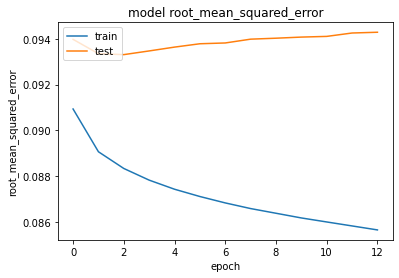

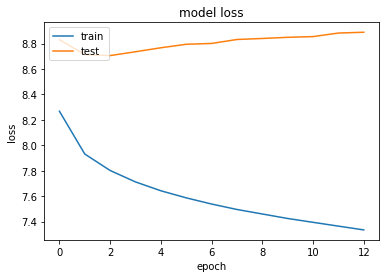

In [40]:
#visualise the accuracy and losses of the model
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['root_mean_squared_error'])
plt.plot(results.history['val_root_mean_squared_error'])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
Train_set_indices = range(535)
Train_set_X = np.zeros((len(Train_set_indices), 801, 401,1), dtype=np.float32)
for i in Train_set_indices:
    img = Image.open('bandLimited/input_%03d.png' % (i+1))
    in_img_input = tf.keras.preprocessing.image.img_to_array(img)
    in_img_input = skimage.transform.resize(in_img_input , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
    Train_set_X[i] =in_img_input / 255.0

In [8]:
prediction_images = np.zeros((len(Train_set_X),801,401),dtype=np.float32)
for i in Train_set_indices:
    prediction_image = model.predict(np.expand_dims(Train_set_X[i] , 0))
    prediction_image = prediction_image.squeeze()+Train_set_X[i].squeeze()
    prediction_image = prediction_image*255.0
    prediction_image  = Image.fromarray(prediction_image)
    if prediction_image.mode == "F":
        prediction_image = prediction_image.convert('RGB')
    prediction_image.save('bandLimited_model2/input_%03d.png' % (i+1))
    

In [10]:
def CreateTestSet(test_set_indices,input_dir_test,output_dir_test):
    """
    Function that reads in the test set images as arrays and scales them between 0 and 1
    parameters:test_set_indices: The indices of the the images in the test set
                 input_dir_test: The directory where the input png images are stored
                output_dir_test: The directory where the output png images are stored
    returns: Test_set_X: an array of input images
             Test_set_y: an array of output images
    """
    Test_set_X = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
    Test_set_y = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
    for i,n in enumerate(test_set_indices):
        img = Image.open(input_dir_test+'/input_%03d.png' % (n+1))
        in_img_input = tf.keras.preprocessing.image.img_to_array(img)
        in_img_input = skimage.transform.resize(in_img_input , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
        Test_set_X[i] =in_img_input / 255.0

        img = Image.open(output_dir_test+'/target_%03d.png' % (n+1))
        in_img_output = tf.keras.preprocessing.image.img_to_array(img)
        in_img_output = skimage.transform.resize(in_img_output , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
        Test_set_y[i] =in_img_output / 255.0    
    print('Done')
    return Test_set_X, Test_set_y
#run for all test sets
for dataset in ['','CIRS_','carotid_']:
    if dataset == '':
        test_set_indices = range(535,669)
        input_dir_test = 'bandLimited'
        output_dir_test = 'groundTruth'
    if dataset == 'CIRS_':
        test_set_indices = range(11)
        input_dir_test = 'CIRSBandLimited'
        output_dir_test = 'CIRSGroundTruth'
    if dataset =='carotid_':
        test_set_indices = range(70)
        input_dir_test = 'carotidBandLimited'
        output_dir_test = 'carotidGroundTruth'
    Test_set_X, Test_set_y = CreateTestSet(test_set_indices,input_dir_test,output_dir_test)
    #create an array with all the predicted images for the test set
    prediction_images = np.zeros((len(Test_set_X),801,401),dtype=np.float32)
    for i in range(len(Test_set_X)):
        prediction_image = model.predict(np.expand_dims(Test_set_X[i] , 0))
        prediction_images[i] = prediction_image.squeeze()+Test_set_X[i].squeeze()
    #save the predicted images array as a npy file
    np.save('Model_output_test_'+dataset+'model2_ultrasound.npy',prediction_images)
    

Done


In [11]:
prediction_images = np.zeros((len(Test_set_X),801,401),dtype=np.float32)
for i in range(len(Test_set_X)):
    prediction_image = model.predict(np.expand_dims(Test_set_X[i] , 0))
    prediction_images[i] = prediction_image.squeeze()+Test_set_X[i].squeeze()
np.save('Model_output_test_carotid_model2_ultrasound.npy',prediction_images)

In [7]:
#Show the nth image in the test set
n =6

#make the model predicted image
prediction = model.predict(np.expand_dims(Test_set_X[n] , 0))
prediction_image = prediction.squeeze()

fig,ax = plt.subplots(1,3, figsize=(12,6))
#bandwidth limited image
ax[0].imshow(Test_set_X[n].squeeze(),cmap = 'gray')
#Model generated image
ax[1].imshow(Test_set_X[n].squeeze()+prediction_image,cmap='gray')
#original image
ax[2].imshow(Test_set_y[n].squeeze(),cmap='gray')
plt.show()

NameError: name 'Test_set_X' is not defined